Steady-state convection-diffusion equation
\begin{align*}
-\varepsilon \Delta u + {\bf \beta} \cdot \nabla u &= 0, \quad \text{in } \Omega \\
u&=u^b \quad \text{on } \Gamma_D \\
-\varepsilon \nabla u \cdot {\bf n} &=0 \quad \text{on } \Gamma_N
\end{align*}

In [1]:
using LinearAlgebra
using GradientRobustMultiPhysics
using ExtendableGrids
using GridVisualize
using ExtendableSparse
using SparseArrays

Consider the smooth solution 
$$
u(x,y) := xy(x-1)(y-1) + x
$$

In [2]:
function get_problem_data(ν)
    α = DataFunction([0.1]; name = "α")
    β = DataFunction([1, 0]; name = "β")
    function exact_u!(result,x)
        result[1] = x[1]*x[2]*(x[1]-1)*(x[2]-1) + x[1]
    end
    u = DataFunction(exact_u!, [1,2]; name = "u", dependencies = "X", bonus_quadorder = 4)
    ∇u = eval_∇(u) # handler for easy eval of AD jacobian
    Δu = eval_Δ(u) # handler for easy eval of AD Laplacian
    function rhs!(result, x) # computes -νΔu + β⋅∇u + αu
        result[1] = -ν*Δu(x)[1] + dot(β(), ∇u(x)) + dot(α(), u(x))
        return nothing
    end    
    f = DataFunction(rhs!, [1,2]; name = "f", dependencies = "X", bonus_quadorder = 3)
    return α, β, u, ∇(u), f
end

get_problem_data (generic function with 1 method)

In [3]:
## custom bilinearform that can assemble the full PDE operator
function ReactionConvectionDiffusionOperator(α, β, ν)
    function action_kernel!(result, input)
        ## input = [u,∇u] as a vector of length 3
        result[1] = α()[1] * input[1] + dot(β(), view(input, 2:3))
        result[2] = ν * input[2]
        result[3] = ν * input[3]
        ## result will be multiplied with [v,∇v]
        return nothing
    end
    action = Action(action_kernel!, [3,3]; bonus_quadorder = max(α.bonus_quadorder,β.bonus_quadorder))
    return BilinearForm([OperatorPair{Identity,Gradient},OperatorPair{Identity,Gradient}], action; 
        name = "ν(∇u,∇v) + (αu + β⋅∇u, v)", transposed_assembly = true)
end

ReactionConvectionDiffusionOperator (generic function with 1 method)

Linear system of equations
\begin{align*}
A u = f \quad \text{with } A=(a_{ij})_{i,j=1}^n\in \mathbb{R}^{n\times n} \\
\sum_{j=1}^n a_{ij}u_j = f_i, \qquad i=1,\ldots,n
\end{align*}

Define a symmetric artificial diffusion matrix $D$
$$
D = d_{ij} = d_{ji} = -\max\{a_{ij}, 0, a_{ji}\}, \text{ for } i\neq j, \quad d_{ii}=\sum_{j=2, j\neq i}^n d_{ij}
$$

In [4]:
function compute_matrix_D(A)
    # run over all dofs
    # loop over ....ndofs = 
    # {  
    # loop i over rowptr
    # {
    #   col_index != i
    # }
    #}
    
end

compute_matrix_D (generic function with 1 method)

In [5]:
function run_main(; ν=1e-5, nlevels=3)
    # load initial mesh
    xgrid = grid_unitsquare(Triangle2D)
    # problem data
    α, β, u, ∇u, f = get_problem_data(ν)
    FEType = H1Pk{1,2,1}
    FES = FESpace{FEType}(xgrid)
        
    xgrid = uniform_refine(xgrid, nlevels)
    FES = FESpace{FEType}(xgrid)
    # solution vector
    Solution = FEVector("u_h", FES)
    
    dt = Array{BoundaryData,1}(undef,0)
    push!(dt,BoundaryData(BestapproxDirichletBoundary; regions = [3,4], data=u))
    dofs = boundarydata!(Solution[1], dt)
    
    ## stiffness matrix
    A = FEMatrix{Float64}(FES)
    assemble_operator!(A[1,1], ReactionConvectionDiffusionOperator(α, β, ν))
    # @show A.entries
    rhs = FEVector{Float64}(FES)
    assemble_operator!(rhs[1], LinearForm(Identity, f))
    
    # for Neumann
    #rhs1 = FEVector{Float64}(FES)
    #assemble_operator!(rhs1[1], LinearForm(Identity, g; AT=ON_BFACES, regions=[1,2])) # g is problem data
    
    # construction of D matrix
    flush!(A.entries)
    D = FEMatrix{Float64}(FES)
    cscmat::SparseMatrixCSC{Float64,Int64} = A.entries.cscmatrix
    #rows::Array{Ti,1} = rowvals(cscmat)
    #valsA::Array{Tv,1} = cscmat.nzval
    colptr::Vector{Int64} = cscmat.colptr
    rowval::Vector{Int64} = cscmat.rowval
    nzval::Vector{Float64} = cscmat.nzval
    
    k_ij = zero(Float64)
    k_ji = zero(Float64)
    DE = D.entries
    
    @time for i = 1 : FES.ndofs
        for c in colptr[i]:(colptr[i+1]-1)            
            j = rowval[c];
            if j!==i
                k_ij = nzval[c]
                # transposed entry
                for ll in colptr[j]:(colptr[j+1]-1)
                    if rowval[ll] == i
                        k_ji = nzval[ll]
                        break
                    end
                end
                DE[j,i] = min(-k_ij , 0.0 , -k_ji)
            else
                DE[j,j] = -1
            end
        end # endfor c
    end
    # diagonal
    flush!(D.entries)
    Dcscmat::SparseMatrixCSC{Float64,Int64} = D.entries.cscmatrix
    Dcolptr::Vector{Int64} = Dcscmat.colptr
    Drowval::Vector{Int64} = Dcscmat.rowval
    Dzval::Vector{Float64} = Dcscmat.nzval
    for i = 1 : FES.ndofs
        ll = -1
        val = zero(Float64)
        for c in Dcolptr[i]:(Dcolptr[i+1]-1)            
            val = val + Dzval[c]
            j = Drowval[c]
            if j==i
                ll = c
            end
        end
        Dzval[ll] = -val
    end
    
    # check symmetric?
    # println(norm(D.entries-D.entries'))
    # @show D.entries
    # check the M-matrix TODO??
    FMatrix = FEMatrix{Float64}(FES)
    Fcscmat::SparseMatrixCSC{Float64,Int64} = FMatrix.entries.cscmatrix    
    Fcolptr::Vector{Int64} = Fcscmat.colptr
    Frowval::Vector{Int64} = Fcscmat.rowval
    Fzval::Vector{Float64} = Fcscmat.nzval
    
    for i = 1 : FES.ndofs
        for c in Dcolptr[i]:(Dcolptr[i+1]-1)
            index = Drowval[c]
            # Fzval[c] 
        end
    end
    # nonlinear loop 
    
    # setting dirichlet dofs
    for dof in dofs
        rhs[1][dof] = 1e60 * Solution[1][dof]
        A[1,1][dof,dof] = 1e60
    end
    
    flush!(A.entries)
    Solution.entries[:] = A.entries \ rhs.entries
    #solve!(Solution, Problem)
    
    L2Error = L2ErrorIntegrator(u, Identity)
    H1Error = L2ErrorIntegrator(∇u, Gradient)    
    L2 = sqrt(evaluate(L2Error,Solution[1]))
    H1 = sqrt(evaluate(H1Error,Solution[1]))
    println("L2: ", L2, " H1 ", H1)
    println("done: ", FES.ndofs)
    (L2, H1)
end

run_main (generic function with 1 method)

In [6]:
function convergence_test(ns)
    H1=[]; L2=[]
    for n = 1 : ns
        l2, h1 = run_main(ν=1e-0, nlevels=n)
        push!(H1, h1)
        push!(L2, l2)
    end
    (L2, H1)
end

convergence_test (generic function with 1 method)

In [7]:
L2, H1 = convergence_test(4)

┌ Warning:  21830790 allocations during ITEMTYPE_BFACE volume calculation
└ @ ExtendableGrids ~/.julia/packages/ExtendableGrids/XFxI3/src/derived.jl:937


  0.073507 seconds (54.51 k allocations: 2.791 MiB, 38.01% gc time, 99.90% compilation time)
L2: 0.11535030287177803 H1 0.38850279922402614
done: 13
  0.000017 seconds (215 allocations: 8.844 KiB)
L2: 0.11315854535366911 H1 0.4052950659333557
done: 41
  0.000049 seconds (807 allocations: 32.344 KiB)
L2: 0.11253136224886941 H1 0.41148978446635526
done: 145
  0.000168 seconds (3.62 k allocations: 199.938 KiB)
L2: 0.11236186690804757 H1 0.41366798339045285
done: 545


(Any[0.11535030287177803, 0.11315854535366911, 0.11253136224886941, 0.11236186690804757], Any[0.38850279922402614, 0.4052950659333557, 0.41148978446635526, 0.41366798339045285])

L2uAny[0.11535030287177803, 0.11315854535366911, 0.11253136224886941, 0.11236186690804757]
L2pAny[0.38850279922402614, 0.4052950659333557, 0.41148978446635526, 0.41366798339045285]


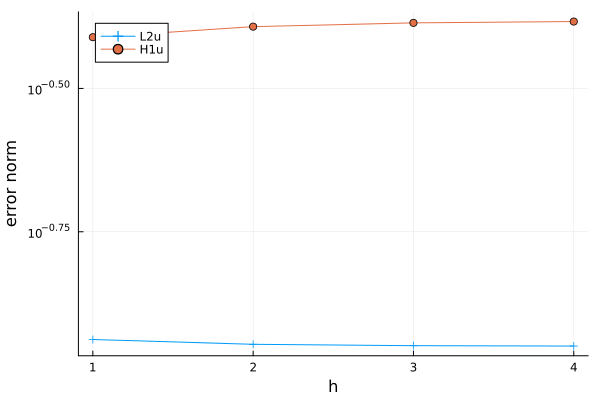

In [8]:
using Plots
println("L2u", L2)
println("L2p", H1)
taus = [1, 2, 3, 4]
plot(taus,[L2 H1],
    yaxis=:log10,
    label=["L2u" "H1u"],
    shape=:auto,
    xlabel="h",ylabel="error norm")